In [1]:
#!pip3 install seaborn

In [2]:
import sys, os, re
import numpy as np
import pandas as pd
from collections import Counter
from collections import deque

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

import essentia, essentia.standard, essentia.streaming
import essentia.standard as ess
from essentia.standard import BeatTrackerMultiFeature
from essentia.standard import ChordsDetectionBeats
from essentia.streaming import *

import mir_eval
import seaborn as sns
from pylab import savefig
import glob
from music21 import *
import json

In [3]:
'''
UTILS 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def tuning(infile):
    hopSize = 2048
    frameSize = 8192
    loader = MonoLoader(filename=infile)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="frequency",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    tuning = TuningFrequency()
    # use pool to store data
    pool = essentia.Pool()
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> tuning.magnitudes
    spectralpeaks.frequencies >> tuning.frequencies
    tuning.tuningFrequency >> (pool, 'tonal.tuningFrequency')
    tuning.tuningCents >> (pool, 'tonal.tuningCents')
    # network is ready, run it
    essentia.run(loader)
    return np.average(pool['tonal.tuningFrequency'])

class ChordSegment :
    startTime = 0.0
    endTime = 0.0
    symbol = ''
    def __init__(self, startTime, endTime, symbol):
        self.startTime = startTime
        self.endTime = endTime
        self.symbol = symbol
    def __repr__(self):
        return str(self.startTime) + '\t' + str(self.endTime) + '\t' + self.symbol
    
def mergeSegments(chordSegments) :
    if (len(chordSegments) < 2) :
        return chordSegments
    res = []
    currentSegment = chordSegments[0]
    for segment in chordSegments[1:] :
        if (segment.symbol == currentSegment.symbol):
            currentSegment.endTime = segment.endTime
        else:
            res.append(currentSegment)
            currentSegment = segment
    res.append(currentSegment)
    return res

def convertChordLabels(chordSegments) :
    for segment in chordSegments :
        segment.symbol = re.sub('m$', ':min', segment.symbol)
    return chordSegments


def toMirexLab(startTime, endTime, onsets, symbols, strengths) :
    if (len(onsets) < len(symbols) or len(symbols) != len(strengths)) :
        raise ValueError("inappropriate lists lengths")
    if (len(onsets) == len(symbols)) :
        onsets = np.concatenate((onsets, [endTime]))
    res = []
    if (startTime < onsets[0]) :
        res.append(ChordSegment(startTime, onsets[0], 'N'))
    for i in range(len(symbols)) :
        sym = symbols[i] if strengths[i] > 0 else 'N'
        res.append(ChordSegment(onsets[i], onsets[i+1], sym))
    if (res[-1].endTime < endTime) :
        res.append(ChordSegment(res[-1].endTime, endTime, 'N'))
    return convertChordLabels(mergeSegments(res))


def processFiles(inputDir, outputDir, processFunction) :
    for file in [f for f in os.listdir(inputDir) if os.path.isfile(os.path.join(inputDir, f))] :
        name, ext = os.path.splitext(file)
        processFunction(os.path.join(inputDir, file), os.path.join(outputDir, name + '.lab'))

In [4]:
'''
Compute Chords by Frames in Essentia 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def computeChordsByFrames(filename, outfile, frameSize=4096, hopSize=2048, tuningFrequency=440.0):

    #TODO:check pools https://essentia.upf.edu/documentation/essentia_python_tutorial.html 

    pool = essentia.Pool()
    loader = essentia.streaming.MonoLoader(filename=filename)
    
    #get the frames and compute chord detection
    fc = FrameCutter(frameSize=frameSize,
                     hopSize=hopSize,
                     silentFrames='noise')

    w = Windowing(type='blackmanharris62')
    spec = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    
    #TODO learn: https://essentia.upf.edu/documentation/reference/std_HPCP.html
    hpcp = HPCP(
        size=12,
        referenceFrequency = tuningFrequency,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitMax')
    
    #TODO: check parameters https://essentia.upf.edu/documentation/reference/std_ChordsDetection.html
    chords = ChordsDetection()
    chords_desc = ChordsDescriptors()


    # connect algorithms together
    loader.audio >> fc.signal
    fc.frame >> w.frame >> spec.frame
    spec.spectrum >> spectralpeaks.spectrum
    spec.spectrum >> (pool, 'spectrum.magnitude') #mine
    spectralpeaks.frequencies >> hpcp.frequencies
    spectralpeaks.magnitudes >> hpcp.magnitudes
    hpcp.hpcp >> (pool, 'chroma.hpcp')  #mine
    hpcp.hpcp >> chords.pcp
    chords.chords >> (pool, 'chords.chords')
    chords.strength >> (pool, 'chords.strength')

    essentia.run(loader)

    audio = essentia.standard.MonoLoader(filename = filename)()
    endTime = len(audio) / 44100.0
    stamps = np.arange(0, endTime, float(hopSize/44100.0))
    stamps = np.array([round(stamp,2) for stamp in stamps]) #2 decimals

    # workaround for Essentia behaviour I don't quite undestand: https://github.com/seffka/ACE2017/blob/467068d9667de43de8b8b8396e620d9e62a0d85c/essentia_chords.py
    syms = list(pool['chords.chords'][:-1])
    strengths = list(pool['chords.strength'][:-1])
    segments = toMirexLab(0.0, endTime, stamps, syms, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
    #print("\n", outfile, " was written")

    
    spectrum= pool['spectrum.magnitude']
    chroma= pool['chroma.hpcp']
    chords= pool['chords.chords']
    chords_strength= pool['chords.strength']
    
    return spectrum, chroma, chords, chords_strength

In [5]:

def computeChordsByBeats(filename, outfile, hopSize=4096, frameSize=8192, tuningFrequency=440.0):
    
    # use pool to store data
    pool = essentia.Pool()
    # initialize algorithms we will use
    loader = MonoLoader(filename=filename)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    hpcp = HPCP(size=12,
                referenceFrequency = tuningFrequency,
                harmonics = 8,
                bandPreset = True,
                minFrequency = 40.0,
                maxFrequency = 5000.0,
                bandSplitFrequency = 500.0,
                weightType = "cosine",
                nonLinear = True,
                windowSize = 1.0)

    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')

    essentia.run(loader)
    
    #print('Loading audio file...', filename)
    audio = ess.MonoLoader(filename = filename)()
    bt = ess.BeatTrackerMultiFeature()
    beats, confidence = bt(audio)
    beats = np.array([round(beat,2) for beat in beats])
    
    #ticks = beats[::4] # TODO: should we take each 4 beats??
    #print("number of beats", len(beats))

    computeChordsByBeats = ChordsDetectionBeats(hopSize=hopSize)
    chords, strengths = computeChordsByBeats(pool['chroma.hpcp'], beats)
    
    segments = toMirexLab(0.0, len(audio) / 44100.0, beats, chords, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
    #print("\n", outfile, " was written")
    
    
    return chords, strengths, beats

In [6]:
def evaluateTriads(estimate_file, reference_file):
    '''
    expects .lab files
    performs mir_eval on triads
    return an object called result '''
    (ref_intervals, ref_labels) = mir_eval.io.load_labeled_intervals(reference_file)
    (est_intervals, est_labels) = mir_eval.io.load_labeled_intervals(estimate_file)

    est_intervals, est_labels = mir_eval.util.adjust_intervals(
        est_intervals, est_labels, ref_intervals.min(),
        ref_intervals.max(), mir_eval.chord.NO_CHORD,
        mir_eval.chord.NO_CHORD)

    (intervals,
     ref_labels,
     est_labels) = mir_eval.util.merge_labeled_intervals(
        ref_intervals, ref_labels, est_intervals, est_labels)

    durations = mir_eval.util.intervals_to_durations(intervals)
    comparisons = mir_eval.chord.triads(ref_labels, est_labels)
    score = mir_eval.chord.weighted_accuracy(comparisons, durations)
    
    #create a result object and save all that might be handy
    class Object(object):
        pass
    
    result = Object()
    result.durations = durations
    result.comparisons = comparisons
    result.score = score
    result.intervals = intervals
    result.ref_labels = ref_labels
    result.est_labels = est_labels

    return result

In [7]:
def evaluate_track(track_path):
    '''
    Process the track with chord by frames and by beats, perform mir_eval and return evaluation for both methods
    '''
    references_path = './ref_labs/'
    estimated_chord_beat_path = './estimated_chordBeat_labs/'
    estimated_chord_frame_path = './estimated_chordFrame_labs/'
    
    #get the .lab filepath
    track_name = os.path.basename(track_path)
    lab_name = os.path.splitext(track_name)[0] + '.lab'

    #filenames
    reference_lab = references_path + lab_name
    estimated_chordBeat_lab = estimated_chord_beat_path + lab_name
    estimated_chordFrame_lab = estimated_chord_frame_path + lab_name

    #create lab files
    song_tuning = tuning(track_path)
    computeChordsByBeats(track_path, estimated_chordBeat_lab, tuningFrequency=song_tuning)
    computeChordsByFrames(track_path, estimated_chordFrame_lab, tuningFrequency=song_tuning)

    #evaluate chord By Beat
    beat_mir_eval_result = evaluateTriads(estimated_chordBeat_lab, reference_lab)

    #evaluate chords By Frame
    frame_mir_eval_result = evaluateTriads(estimated_chordFrame_lab, reference_lab)
    
    return beat_mir_eval_result, frame_mir_eval_result

In [8]:
'''
Persisting dictionary as json utilities: 
this will allow to save the ongoing results into jsons, and later we can check if a song was already analised 
so we don't analise it again. Like this we can run the code in different sessions!
'''

def persist_dict_into_json(dictionary, json_name):
    file = open(json_name+".json", "w")
    file.write(json.dumps(dictionary, indent=4, sort_keys=True)) #make it pretty-printed and sorted
    file.close()
    
def load_json_as_dict(json_name):
    '''
    load dictionary form json, throws error if no file was found
    '''
    file = open(json_name+".json", "r")
    data = json.load(file)
    file.close()
    return data

def persist_all_dictionaries(updated_dictionaries, dictionary_names, persist_path='./results/estimation_jsons_all_dataset/'):
    '''
    will update the already persisted results with the newly computed ones, and save to disk.
    Expects a list of dictionaries and a list of same size and order for the dictionary names.
    '''
    for updated, name in zip(updated_dictionaries, dictionary_names):
        dictionary_path = persist_path + name
        combined_dict = dict()
        try:
            persisted = load_json_as_dict(dictionary_path) #previous updated dicitonary
            combined_dict.update(persisted)
            combined_dict.update(updated)
        except:
            print("will create a json dictionary in: ", dictionary_path+'.json' )
            combined_dict = updated            
        persist_dict_into_json(
            combined_dict, #update the persisted dictionary with the new values
            dictionary_path) 


# Computing ACE for all tracks

TODO: In here we will process the provided file list. Could be the whole dataset or a subset, or oven one single file.



### Utilities:
We need to create some helper functions that will create the dictionaries that will be used afterwards for analysing the results.
 TODO:
 Explain 2 kinds of dicitonary
The following function will find the most common mistakes for each chord(rank wrongly estimated chords by occurrence)

In [9]:
def create_mistakes_count(evaluation_result): 
    '''
    receives an evaluation result and creates a mistakes_count dictionary.

    *example mistakes_count: 
    {
    "['A:dim7', 'C:min']": 2,
     "['A:dim7', 'D#']"   : 3
     }
    
    '''
    mistakes_count = dict()
    zipped = zip(
        evaluation_result.ref_labels, #ground truth
        evaluation_result.est_labels, #chord estimation results
        evaluation_result.comparisons) 
    
    for reference, estimation, comparison in zipped:     
        if comparison == 1: #If there was no mistake, continue
            continue       
        #Count overall mistakes    
        mistake_key = str([reference, estimation]) #dictionary key as 'truthChord_estimatedChord'
        if mistake_key not in mistakes_count:
            mistakes_count[mistake_key] = 0
        mistakes_count[mistake_key]+=1        
    return mistakes_count


def create_mistakes_by_chord(evaluation_result): 
    '''
    receives an evaluation result and creates a mistakes_count dictionary and a mistakes_by_chord dictionary.

    *example mistakes_by_chord:
     {
     'Ab:7' : {'C#': 3, 'D#:min': 1, 'F:min': 1},
     'Ab:min': {'C#:min': 1, 'G#': 3}
     }
    
    '''
    mistakes_by_chord = dict() 
    zipped = zip(
        evaluation_result.ref_labels, #ground truth
        evaluation_result.est_labels, #chord estimation results
        evaluation_result.comparisons)
    
    for reference, estimation, comparison in zipped:    
        if comparison == 1: #If there was no mistake, continue
            continue
        #Count for each chord
        if reference not in mistakes_by_chord:
            mistakes_by_chord[reference] = dict()
        if estimation not in mistakes_by_chord[reference]:
            mistakes_by_chord[reference][estimation] = 0
        mistakes_by_chord[reference][estimation]+=1   
    return mistakes_by_chord


def get_track_name(track_path):
    return os.path.basename(track_path)

## Main Function:
`evaluate_tracks_and_fill_global_dictionary` will process the provided list of tracks.
This is a reusable function that can be used later to create the dictionaries for a particular subset. 
For now, we will process the **whole dataset**
The .json results will be saved in `persist_path_all_dataset` path.

*Note:* We have pointed our .flac audio dataset inside `audios_path`. You can update this path

In [91]:
audios_path = './audios/'
output_persist_path_all_dataset = './results/estimation_jsons_all_dataset/'

#get all audio track paths
all_audio_tracks = glob.glob(audios_path + '*.flac', recursive = True)


def evaluate_tracks_and_fill_global_dictionary(tracks, output_path):
    '''will evaluate the tracks in the given list, and persist the dictionaries with information for next analsis steps'''
    for index, track in enumerate(tracks):
        try:
            #first,we check if a track was already processed (we only need to check one of the dictionaries)
            persistedData = load_json_as_dict('./results/estimation_jsons_all_dataset/global_frames_scores')
            if(get_track_name(track) in persistedData):
                print ('Already processed audio file: ', index+1, '/', len(tracks), '\t', track)
                continue
        except:
            print("no dictionary found, will create later... \n")
            
            
        try:
            beat_mir_eval_result, frame_mir_eval_result = evaluate_track(track)
        except Exception as e:
            print('\n\n', track, ' got an exception during analisis or mir_eval: ', e, '\n\n')
            continue #if error, go to the next one (but it should happen, so better take a look!)

        print ('Processing audio file: ', index+1, '/', len(tracks), '\t', track)

        key = get_track_name(track) # the key is the name of the file

        #create new dictionaries for both beat and frame with track name as key
        updated_dictionaries_to_persist = [
            dict([(key, create_mistakes_count(beat_mir_eval_result))]),
            dict([(key, create_mistakes_by_chord(beat_mir_eval_result))]),
            dict([(key, beat_mir_eval_result.score)]),
            dict([(key, create_mistakes_count(frame_mir_eval_result))]),
            dict([(key, create_mistakes_by_chord(frame_mir_eval_result))]),
            dict([(key, frame_mir_eval_result.score)]),
        ]
        #these will be the final names of the persisted dictionaries created above
        dictionary_names = [ 
            'global_beats_mistakes_count',
            'global_beats_mistakes_by_chord',
            'global_beats_scores',
            'global_frames_mistakes_count',
            'global_frames_mistakes_by_chord',
            'global_frames_scores'
        ]
        #save results on disk
        persist_all_dictionaries(updated_dictionaries_to_persist, dictionary_names, output_path)
    #on finish:    
    print("All tracks have been processed, they were stored in .json files in " + output_path)
    
    
#Finally, we call the evaluation:
evaluate_tracks_and_fill_global_dictionary(all_audio_tracks, output_persist_path_all_dataset)


Already processed audio file:  1 / 112 	 ./audios/parkers_mood.flac
Already processed audio file:  2 / 112 	 ./audios/grandpas_spells.flac
Already processed audio file:  3 / 112 	 ./audios/evidence.flac
Already processed audio file:  4 / 112 	 ./audios/four_or_five_times.flac
Already processed audio file:  5 / 112 	 ./audios/for_dancers_only.flac
Already processed audio file:  6 / 112 	 ./audios/haig_and_haig.flac
Already processed audio file:  7 / 112 	 ./audios/hotter_than_that.flac
Already processed audio file:  8 / 112 	 ./audios/east_st_louis.flac
Already processed audio file:  9 / 112 	 ./audios/honeysuckle_rose.flac
Already processed audio file:  10 / 112 	 ./audios/black_water_blues.flac
Already processed audio file:  11 / 112 	 ./audios/st_thomas.flac
Already processed audio file:  12 / 112 	 ./audios/work_song.flac
Already processed audio file:  13 / 112 	 ./audios/bags_groove.flac
Already processed audio file:  14 / 112 	 ./audios/doggin_around.flac
Already processed audio f

TODO: explain agregated dicitonaries

In [11]:
#compute aggregation for a number of tracks, could be a list by genres, or like in this case, for all the complete dataset

def create_aggregated_dict(tracks, mistake_count_dict):
    '''
    Will return a dictionary with all mistakes for the requested tracks aggregated.
    Expects a list of tracks and a dictionary where the keys are track names, and values are mistake_count dictionaries
    '''
    aggregated_dict = dict()
    for track in tracks:
        trackname = get_track_name(track)
        if(trackname not in mistake_count_dict):
            print(trackname, ' was not in the dictionary, did you specify the track list correctly?')
            continue
            
        for mistake in mistake_count_dict[trackname]:
            if mistake not in aggregated_dict: 
                aggregated_dict[mistake] = mistake_count_dict[trackname][mistake]
            else: aggregated_dict[mistake] += mistake_count_dict[trackname][mistake]       
    return aggregated_dict


def create_aggregated_by_chord_dict(tracks, mistake_by_chord_dict):
    '''
    Will return a dictionary with all mistakes for the requested tracks aggregated.
    Expects a list of tracks and a dictionary where the keys are track names, and values are mistake_count dictionaries
    '''
    aggregated_dict = dict()
    for track in tracks:
        trackname = get_track_name(track)
        if(trackname not in mistake_by_chord_dict):
            print(trackname, ' was not in the dictionary, did you specify the track list correctly?')
            continue
            
        for chord in mistake_by_chord_dict[trackname]:
            if chord not in aggregated_dict: 
                aggregated_dict[chord] = mistake_by_chord_dict[trackname][chord]   
            else:
                #we need to update the chord dictionary:
                for mistake_chord in mistake_by_chord_dict[trackname][chord]:
                    mistake_chord_val = mistake_by_chord_dict[trackname][chord][mistake_chord]
                    if mistake_chord not in aggregated_dict[chord]:
                        aggregated_dict[chord][mistake_chord] = mistake_chord_val
                    else:
                         aggregated_dict[chord][mistake_chord] += mistake_chord_val
    return aggregated_dict

#load and create aggregation for mistakes count dictionary:
global_beats_mistakes_count = load_json_as_dict(output_persist_path_all_dataset+"global_beats_mistakes_count")
global_frames_mistakes_count = load_json_as_dict(output_persist_path_all_dataset+"global_frames_mistakes_count")
dict_comparelabels_beat_all = create_aggregated_dict(all_audio_tracks, global_beats_mistakes_count)
dict_comparelabels_frame_all = create_aggregated_dict(all_audio_tracks, global_frames_mistakes_count)

#load and create aggregation for mistakes by chord  dictionary:
global_beats_mistakes_by_chord = load_json_as_dict(output_persist_path_all_dataset+"global_beats_mistakes_by_chord")
global_frames_mistakes_by_chord = load_json_as_dict(output_persist_path_all_dataset+"global_frames_mistakes_by_chord")
dict_foreachchord_beat_all = create_aggregated_by_chord_dict(all_audio_tracks,global_beats_mistakes_by_chord)
dict_foreachchord_frame_all = create_aggregated_by_chord_dict(all_audio_tracks, global_frames_mistakes_by_chord)


maple_leaf_rag(bechet).flac  was not in the dictionary, did you specify the track list correctly?
maple_leaf_rag(bechet).flac  was not in the dictionary, did you specify the track list correctly?
maple_leaf_rag(bechet).flac  was not in the dictionary, did you specify the track list correctly?
maple_leaf_rag(bechet).flac  was not in the dictionary, did you specify the track list correctly?


# Analysing the results


TODO

```python
test code display

```

In [12]:
#print mean scores for score_dictionaries
def compute_score_mean(score_dict, persist_path='./results/estimation_jsons_all_dataset/'):
    '''compute overall scores for a given score dictionary'''
    if len(score_dict) == 0: return None
    aggregated_score = 0
    for key in score_dict:
        aggregated_score += score_dict[key]
    return aggregated_score/len(score_dict)


global_beats_scores = load_json_as_dict(output_persist_path_all_dataset+"global_beats_scores")
global_frames_scores = load_json_as_dict(output_persist_path_all_dataset+"global_frames_scores")

print("Overall accuracy of chord detection by beat: ", compute_score_mean(global_beats_scores), output_persist_path_all_dataset)
print("Overall accuracy of chord detection by frame: ", compute_score_mean(global_frames_scores), output_persist_path_all_dataset)

Overall accuracy of chord detection by beat:  0.22318167629931496 ./results/estimation_jsons_all_dataset/
Overall accuracy of chord detection by frame:  0.31253408942929617 ./results/estimation_jsons_all_dataset/


In [50]:
#Making a heatmap for mistakes the algorithm has made
def make_heatmap(dict_foreach_chord, output_filename, big=True):
    pd_makeheatmap = pd.DataFrame.from_dict(dict_foreach_chord, orient = 'index')
    if (big == True):
        plt.subplots(figsize=(15,70))
    else:
        plt.subplots(figsize=(15,5))
    svm = sns.heatmap(pd_makeheatmap, annot=True, fmt=".0f", cmap="YlGnBu")
    #print("x axis is estimated chords, y axis is the ground truth")
    figure = svm.get_figure()
    plt.show()
    figure.savefig(output_filename+'.png', dpi=200)
    return figure

In [14]:
def get_top_20_mistakes_and_save_csv(dict_comparelabels, output_filename):
    pd_rank = pd.DataFrame.from_dict(dict_comparelabels, orient = 'index')
    pd_rank = pd_rank.reset_index(drop = False)
    pd_rank.columns = ['chord pairs', 'count']
    pd_rank = pd_rank.sort_values(by=['count'], ascending=False)
    
    #Save top 20 in csv file:
    top_20 = pd_rank.iloc[:20].reset_index().drop(['index'], axis=1) 
    top_20.to_csv(output_filename + '.csv')
    return top_20
    
    

In [15]:
top_20_beat_mistakes = get_top_20_mistakes_and_save_csv(dict_comparelabels_beat_all, './results/top_20_mistakes_beat_all_tracks')

#we display the top 5 below:
top_20_beat_mistakes.head(5)

,chord pairs,count
0,"['Bb:7', 'F:min']",458
1,"['Bb:7', 'G:min']",452
2,"['F:7', 'A#']",340
3,"['F:7', 'C:min']",334
4,"['Bb:7', 'G#']",326


In [16]:
top_20_frame_mistakes = get_top_20_mistakes_and_save_csv(dict_comparelabels_frame_all, './results/top_20_mistakes_frame_all_tracks')

#we display the top 5 below:
top_20_frame_mistakes.head(5)

,chord pairs,count
0,"['F:7', 'A#']",572
1,"['Bb:7', 'D#']",531
2,"['Bb:7', 'F:min']",472
3,"['Bb:7', 'G:min']",455
4,"['F:7', 'A#:min']",354


# Compute overall heatmaps for frames and beats results:
TODO explain

### Compute overall heatmap for chord detection algorithm by beat:
y axis is for reference chord (ground truth), x axis is for the estimated chord.

We also save the results in a png file in the the `./results` folder

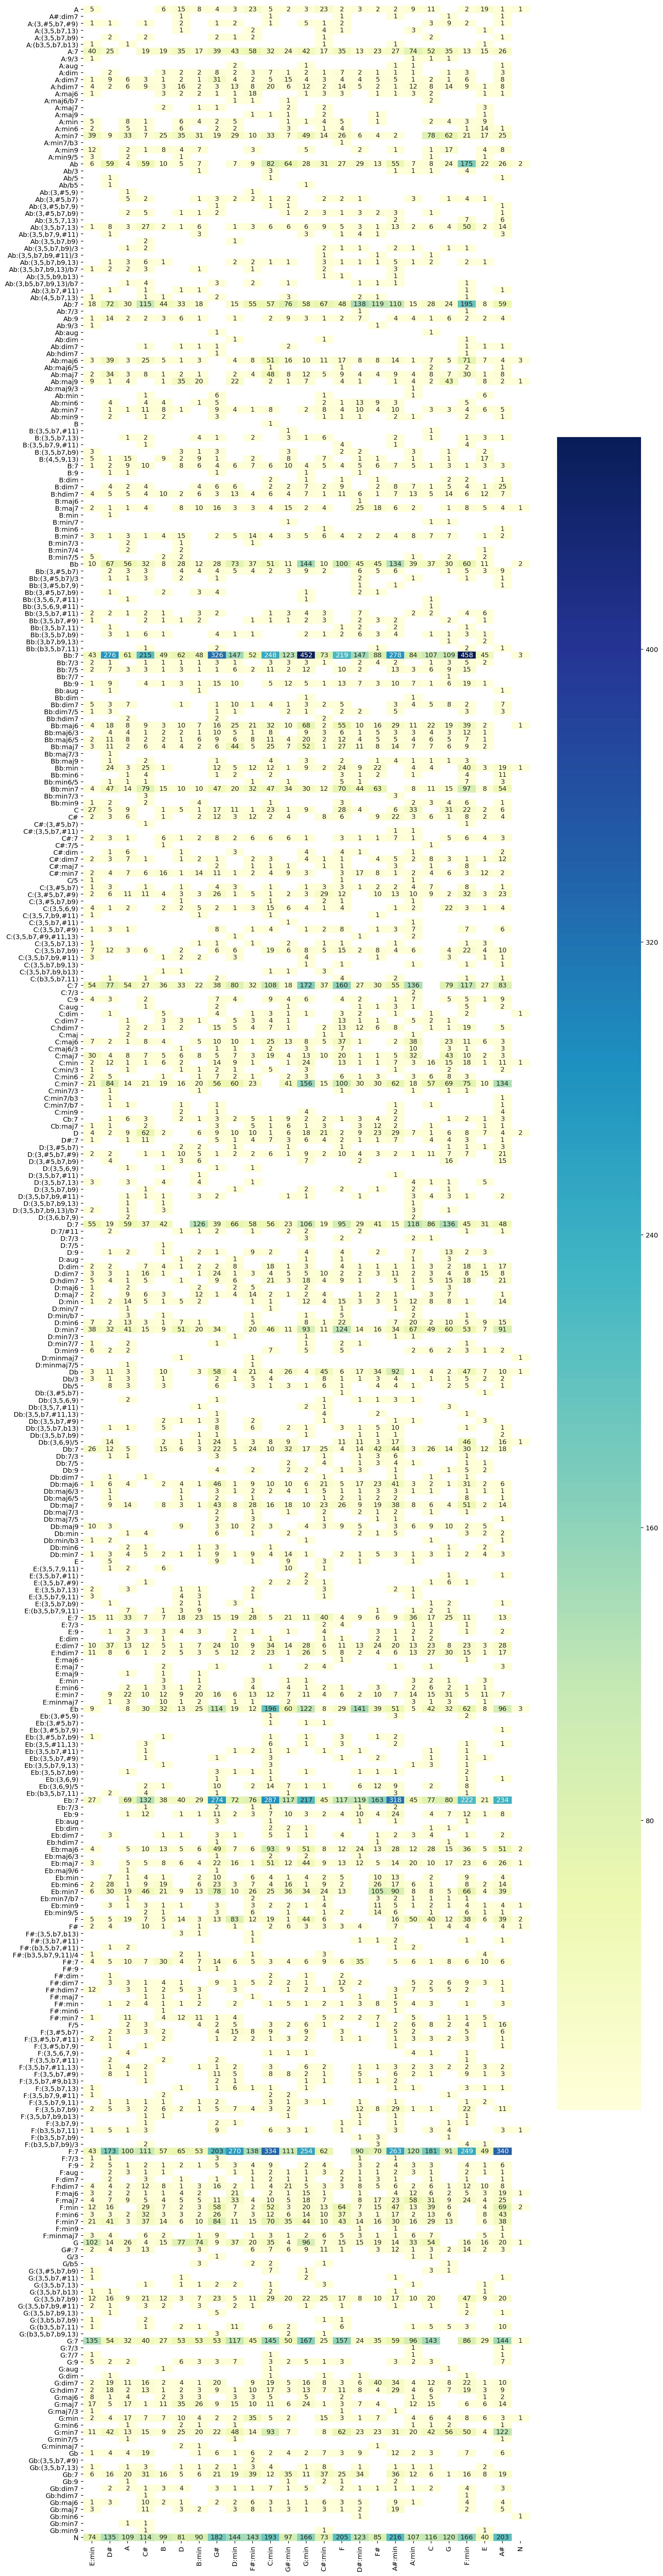

NameError: name 'figure_beat' is not defined

In [17]:
output_filename = './results/overall_beat_heatmap'
figure_beat = make_heatmap(dict_foreachchord_beat_all, output_filename)

### Compute overall heatmap for chord detection algorithm by frame:
y axis is for reference chord (ground truth), x axis is for the estimated chord

We also save the results in a png file in the the `./results` folder

In [ ]:
output_filename = './results/overall_frame_heatmap'
figure_beat = make_heatmap(dict_foreachchord_frame_all, output_filename)

# Compute overall heatmaps for frames and beats results, displaying top mistakes only:


#### Observation: 
The obtained heatmaps are interesting because they comprehend all the available information, but hey are too long to display if we want to take a quick look on the most common mistakes.
This `create_top_mistakes_dictionary` utility function will help us chop the dictionary by the top ranked mistakes, so we can show a reduced version of the results afterwards.


In [46]:
def get_ground_truth_chord(chord_pair):
    ground_truth = chord_pair.split('\',')[0].split('[\'')[1]
    ground_truth = ground_truth.replace('"','')
    return ground_truth


def create_top_mistakes_dictionary(top_mistakes_dataframe, dict_foreachchord):
    '''
    given a ranked dataframe and a dictionary containing the chord mistakes list for a given chord, it will return 
    the given dataframe references from the given dictionary. 
    Example: When you want to get only the top 10 mistakes of a big dictionary, for example for printing heatmap later 
    '''
    top_reference_dict = top_mistakes_dataframe.to_dict()['chord pairs']
    references = []
    for chord_pair in top_reference_dict.values():
        reference = get_ground_truth_chord(chord_pair)
        references.append(reference)
    top_mistakes_dict = dict() 
    for reference in set(references):
        top_mistakes_dict[reference] = dict_foreachchord[reference]
    return top_mistakes_dict
        
    
#create_top_mistakes_dictionary(top_20_frame_mistakes, dict_foreachchord_beat_all)


### Compute overall top mistakes heatmap for chord detection algorithm by beat:
y axis is for reference chord (ground truth), x axis is for the estimated chord.

We also save the results in a png file in the the `./results` folder

Note: Many of the top mistakes belong to the same chord ground truth, that is why the size of the ground truth is smaller than the top-N number

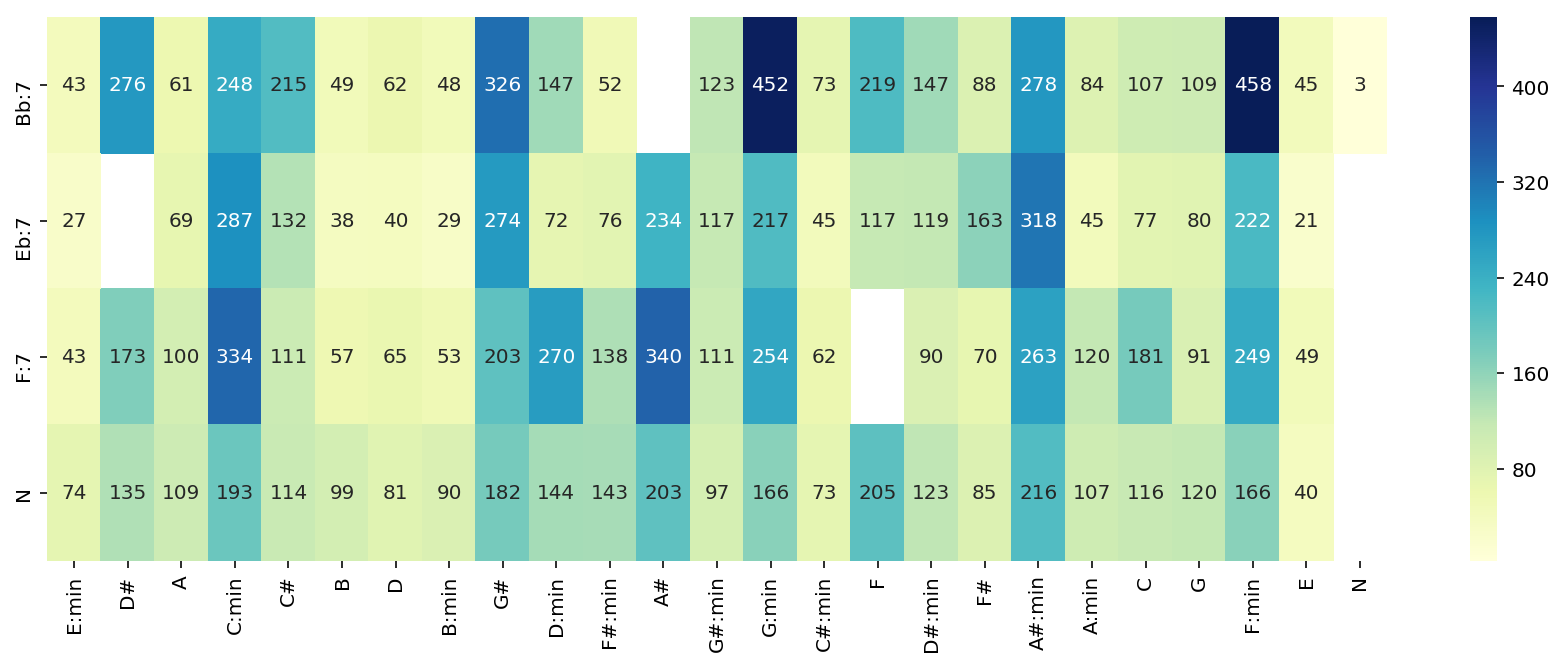

In [54]:
top_mistakes = create_top_mistakes_dictionary(top_20_beat_mistakes, dict_foreachchord_beat_all)
output_filename = './results/overall_top_mistakes_beat_heatmap'

fig = make_heatmap(top_mistakes, output_filename, big=False)


### Compute overall top mistakes heatmap for chord detection algorithm by frame:
y axis is for reference chord (ground truth), x axis is for the estimated chord.

We also save the results in a png file in the the `./results` folder

Note: Many of the top mistakes belong to the same chord ground truth, that is why the size of the ground truth is smaller than the top-N number

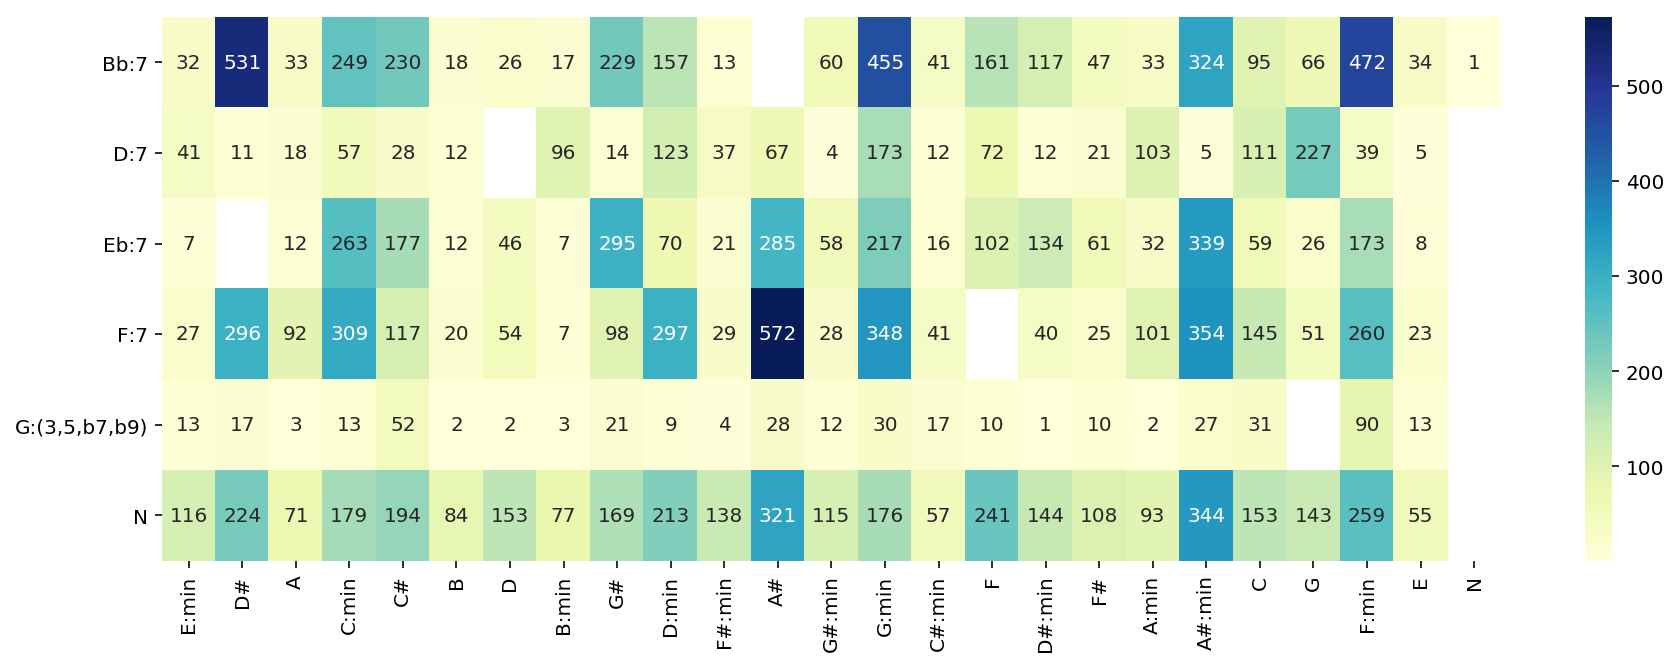

In [55]:
top_mistakes = create_top_mistakes_dictionary(top_20_frame_mistakes, dict_foreachchord_frame_all)
output_filename = './results/overall_top_mistakes_frame_heatmap'

figure_beat = make_heatmap(top_mistakes, output_filename, big=False)

# Computing chord similarity by checking the different notes
TODO explain

In [ ]:
def compute_chords_note_difference(truth_chord, est_chord):
    '''
    Compute how similar are the mistakes: do the mistaken chords share a lot of notes,
    or are they very different between them?
     Note: we are aware that this might be a naive approach, but we think it is relevant to check if chords 
     that are mistaken often share many notes.
    '''
    if(truth_chord == 'N' or est_chord =='N'):
        print("Can't compute distance for N")    
        return None

    chord_qualities = {
        #           1     2     3     4  5     6     7        
        'maj':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],        
        'min':     [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        'aug':     [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        'dim':     [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        'sus4':    [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        'sus2':    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        '7':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'maj7':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
        'min7':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        'minmaj7': [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
        'maj6':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        'min6':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
        'dim7':    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        'hdim7':   [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
        'maj9':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
        'min9':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        '9':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'b9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        '#9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'min11':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        '11':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        '#11':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'maj13':   [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
        'min13':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        '13':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'b13':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        '1':       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        '5':       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        '':        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
    
    
    def create_custom_disposition(chord):
        '''creates a custom disposition for a chord string expressed like (b3,5,7,9) or (b3,5,7)/5 '''
        degrees = chord.replace('(', '' ).replace(')', '').split(',')
        if '/' in degrees[-1]: #has bass, parse it correctly
            bass = degrees.pop(-1)
            bass = bass[bass.index('/')+1:]
            degrees.append(bass)

        disposition = [1,0,0,0,0,0,0,0,0,0,0,0]
        degrees_to_disposition_index = {2: 2, 3: 4, 4: 6, 5: 7, 6: 9, 7: 11, 9: 2, 10: 4, 11: 6, 13: 9}
        for degree in degrees:
            accidental = 0
            if 'b' in degree: #todo dism
                accidental = -1
            if '#' in degree: #todo aug
                accidental = 1


            degree_int = int((''.join( re.findall('\d', degree) ))) #get the integer part (ex from '13b' to 13)
            disposition_index = degrees_to_disposition_index[degree_int] +  accidental #get the index and sum accidental
            disposition[disposition_index] = 1
        return disposition


    def get_root(chord):
        '''returns the root of the chord'''
        if ':' in chord: 
            return chord[0: chord.index(':')]
        elif '/' in chord:
            return chord[0: chord.index('/')]
        return chord


    def get_chord_type(chord):
        '''returns the chord type'''
        try: 
            chord.index(':')       
            return chord[chord.index(':')+1:]
        except: 
            return 'maj'


    def get_notes_disposition(chord):
        '''
        will return a 12-note array with the note disposition for a chord
        example: for a '7' return [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
        '''
        chord_type = get_chord_type(chord)
        if chord_type in chord_qualities:   
            return chord_qualities[chord_type]
        return create_custom_disposition(chord_type)


    def transpose_disposition(dispostion, interval_semitones):
        '''will tranpose(shift) the given disposition the given interval semitones'''    
        items = deque(dispostion)
        items.rotate(interval_semitones)
        return list(items)


    def difference(li1, li2):
        '''counts the different items in two list of the same size'''
        diff_count = 0
        for i in range(len(li1)):
            if li1[i] != li2[i]: diff_count +=1
        return diff_count

    #compute note disposition for each chord:
    truth_disposition = get_notes_disposition(truth_chord)
    estimated_disposition = get_notes_disposition(est_chord)


    #compute distance in semitones between truth and estimation
    truth_root = note.Note(get_root(truth_chord))
    est_root = note.Note(get_root(est_chord))
    interval_semitones = interval.notesToChromatic(truth_root, est_root).semitones

    #we need to transpose the estimated chord to the same root as the ground truth:
    transposed_estimated_disposition = transpose_disposition(estimated_disposition, interval_semitones)

    #now can compare the note disposition between both and count how many different notes
    different_notes = difference(truth_disposition, transposed_estimated_disposition)
    return different_notes
    
    
#test
print(compute_chords_note_difference('Eb:7', 'Ab/3'))

## TODO subset top ranking

In [ ]:
index = 0
for chordname, mistakes in zip(chordnames_frame_all, mistakes_frame_all):
    print("\nreal chordname:", chordname)
    for mistake in mistakes:
        try:
            difference = compute_chords_note_difference(chordname, mistake)
            if difference:
                print("\tmistaken for:", mistake, "\tdistance: ", difference)
        except:
            print('\n got error when computing note difference for chordname', chordname, 'mistake', mistake)

# Analysing subsets:

In order to see if ACE algorithm performs notably different on distinct subsets, we classified songs into different subsets: 
 * Blues, 
 * Old jazz songs(originate before 1930s, including Ragtime, Swing etc.) 
 * Bop, 
 * All_new_jazz (which are created after 1930s, including Bebop, Cool-Jazz, Avant-Garde etc.)
 * new Jazz Without Bop. 
 
 This specific way of classification is based on two conjectures: first of which is the accuracy of ACE’s performance on Blues should be higher than other subsets, since chord information in Blues are more clear than Jazz music in general, while it has easier structure, and involving less instruments. Second is that it should be harder to detect chord on new jazz standards subset, since it includes more improvisations and vagueness in the sense of harmony, which should be more challenging for the ACE algorithm. Furthermore, based on the second conjecture, we compared the Bop pieces in New Jazz Standards subset with other pieces in same subset, we expect the performance on Bop music to be the poorest.


First, we need to define the subsets that we will use:

In [60]:
#subsets:
blues_subset = ['black_water_blues.flac','handful_of_riffs.flac','livery_stable_blues.flac','singin_the_blues.flac',
'dippermouth_blues.flac','in_gloryland.flac','lost_your_head_blues.flac','st_louis_blues.flac']


old_jazz_subset = ['big_butter_and_eggman.flac',                    
'i_gotta_right_to_sing_the_blues.flac',
 'black_and_tan_fantasy.flac',                   
 'ko-ko(ellington).flac',
 'black_bottom_stomp.flac',                       
 'lady_bird.flac',
 'blue_serge.flac',                               
 'manteca.flac',
'body_and_soul(goodman).flac',
 'maple_leaf_rag(braxton).flac',   
 'breakfast_feud.flac',                           
 'maple_leaf_rag(hyman).flac',   
 'concerto_for_cootie.flac',                      
 'mean_to_me.flac',
 'dead_man_blues.flac',                           
 'minor_swing.flac',
 'diminuendo_and_crescendo_in_blue.flac',         
 'moten_swing.flac',
 'dinah.flac',                                    
 'new_east_st_louis.flac',
 'dinah_fats_waller.flac',                        
 'one_oclock_jump.flac',
 'dinah_red_nichols.flac',                        
 'potato_head_blues.flac',
 'django.flac',                                   
 'riverboat_shuffle.flac',
 'doggin_around.flac',                            
 'september_in_the_rain.flac',
 'east_st_louis.flac',                            
 'struttin_with_some_barbecue.flac',
 'embraceable_you.flac',                          
 'sweethearts_on_parade.flac',
 'everybody_loves_my_baby.flac',                  
 'swing_that_music.flac',
 'for_dancers_only.flac',                         
 'thats_a_serious_thing.flac',
 'four_brothers.flac',                            
 'the_golden_bullet.flac',
 'four_or_five_times.flac',                       
 'the_preacher.flac',
 'from_monday_on.flac',                           
 'the_stampede.flac',
 'grandpas_spells.flac',                          
 'these_foolish_things.flac',
 'harlem_congo.flac',                             
 'walkin_shoes.flac',
 'he_s_funny_that_way.flac',                      
 'weather_bird.flac',
 'honeysuckle_rose.flac',                         
 'west_end_blues.flac',
 'honky_tonk_train.flac',                         
 'when_lights_are_low.flac',
 'hotter_than_that.flac',                         
 'wrappin_it_up.flac',
 'i_cant_believe_you_are_in_love_with_me.flac',
 'you_d_be_so_nice_to_come_home_to.flac',
 'i_found_a_new_baby.flac',
'stompin_at_the_savoy.flac',
'lester_leaps_in.flac']
 
    
new_jazz_no_bop_standards = ['all_alone.flac',
'haig_and_haig.flac',
'misterioso.flac', 
'the_man_i_love.flac',
'blue_horizon.flac',
'i_cant_get_started.flac',
'oh_lady_be_good.flac',  
'watermelon_man.flac',
'blues_in_the_closet.flac',
'i_got_rhythm.flac',
'one_by_one.flac',
'west_coast_blues.flac',
'body_and_soul(hawkins).flac',
'in_a_mellotone.flac',
'organ_grinders_swing.flac',
'wrap_your_troubles_in_dreams.flac',
'cotton_tail.flac',
'isfahan.flac',
'rockin_chair.flac',
'cotton_tail_fitzgerald.flac',
'king_porter_stomp.flac',
'girl_from_ipanema.flac',
'lester_leaps_in.flac',
'summertime.flac']

bop_subset = ['airegin.flac',
'dexter_rides_again.flac',
'night_in_tunisia.flac',
'subconscious_lee.flac',
'bags_groove.flac',
'boplicity.flac',
'evidence.flac',
'parkers_mood.flac',
'tricroism.flac',
'bikini.flac',
'crazeology.flac',
'indiana.flac',
'pentup_house.flac',
'work_song.flac',
'blue_7.flac',
'daahoud.flac',
'my_favorite_things.flac',
'shaw_nuff.flac',
'giant_steps.flac',
'moanin.flac',
'my_favorite_things.flac',
'st_thomas.flac']

#we can create combination of subsets!
all_new_jazz = bop_subset.copy()
all_new_jazz.extend(new_jazz_no_bop_standards)


def createTrackList(tracks, audios_path='./audios/'):
    '''returns a usable list track'''
    subset_tracks = []
    for track in tracks:
        subset_tracks.append(audios_path + track)
    return subset_tracks


def create_subset_dictionaries(track_list, output_path, look_up_path = './results/estimation_jsons_all_dataset/'):
    for track in track_list:
        key = get_track_name(track) # the key is the name of the file

        #create new dictionaries for both beat and frame with track name as key   
        updated_dictionaries_to_persist = []
        #these will be the final names of the persisted dictionaries created above
        dictionary_names = [ 
            'global_beats_mistakes_count',
            'global_beats_mistakes_by_chord',
            'global_beats_scores',
            'global_frames_mistakes_count',
            'global_frames_mistakes_by_chord',
            'global_frames_scores'
        ]
        
        for dict_name in dictionary_names:
            persistedData = load_json_as_dict(look_up_path + dict_name)
            updated_dictionaries_to_persist.append(dict([(key, persistedData[key])]))
        
        #save results on disk
        persist_all_dictionaries(updated_dictionaries_to_persist, dictionary_names, output_path)
    #on finish:    
    print("All tracks have been processed, they were stored in .json files in " + output_path)
        

## blues

In [62]:
audios_path = './audios/'
output_persist_path_blues = './results/estimation_jsons_blues_subset/'

blues_tracks = createTrackList(blues_subset)

create_subset_dictionaries(blues_tracks, output_persist_path_blues)


All tracks have been processed, they were stored in .json files in ./results/estimation_jsons_blues_subset/


In [92]:
#compute score mean for Blues
subset_tracks = blues_tracks.copy()

#load and create aggregation for mistakes count dictionary:
blues_beats_mistakes_count = load_json_as_dict(output_persist_path_blues+"global_beats_mistakes_count")
blues_frames_mistakes_count = load_json_as_dict(output_persist_path_blues+"global_frames_mistakes_count")
blues_dict_comparelabels_beat = create_aggregated_dict(subset_tracks, blues_beats_mistakes_count)
blues_dict_comparelabels_frame = create_aggregated_dict(subset_tracks, blues_frames_mistakes_count)

#load and create aggregation for mistakes by chord  dictionary:
blues_beats_mistakes_by_chord = load_json_as_dict(output_persist_path_blues+"global_beats_mistakes_by_chord")
blues_frames_mistakes_by_chord = load_json_as_dict(output_persist_path_blues+"global_frames_mistakes_by_chord")
blues_foreachchord_beat_all = create_aggregated_by_chord_dict(subset_tracks,blues_beats_mistakes_by_chord)
blues_foreachchord_frame_all = create_aggregated_by_chord_dict(subset_tracks, blues_frames_mistakes_by_chord)



#print MEAN
beats_scores = load_json_as_dict(output_persist_path_blues+"global_beats_scores")
frames_scores = load_json_as_dict(output_persist_path_blues+"global_frames_scores")

print("Blues accuracy of chord detection by beat: ", compute_score_mean(beats_scores), output_persist_path_blues)
print("Blues accuracy of chord detection by frame: ", compute_score_mean(frames_scores), output_persist_path_blues)


Blues accuracy of chord detection by beat:  0.21601141780314043 ./results/estimation_jsons_blues_subset/
Blues accuracy of chord detection by frame:  0.3094959089048623 ./results/estimation_jsons_blues_subset/


In [71]:
blues_top_20_beat_mistakes = get_top_20_mistakes_and_save_csv(blues_dict_comparelabels_beat, './results/blues_top_20_mistakes_beat')

#we display the top 5 below:
blues_top_20_beat_mistakes.head(5)


,chord pairs,count
0,"['D', 'C#']",59
1,"['Eb', 'C:min']",49
2,"['Eb', 'D#:min']",47
3,"['Ab:maj9', 'G']",43
4,"['Ab:maj9', 'D']",35


In [72]:
blues_top_20_frame_mistakes = get_top_20_mistakes_and_save_csv(blues_dict_comparelabels_frame, './results/blues_20_mistakes_frame')

#we display the top 5 below:
blues_top_20_frame_mistakes.head(5)


,chord pairs,count
0,"['Ab:maj9', 'D']",68
1,"['Ab:maj9', 'G']",59
2,"['D', 'C#']",56
3,"['Eb', 'D#:min']",43
4,"['Bb:7', 'D#']",37


by beat chord mistake heatmap on blues:


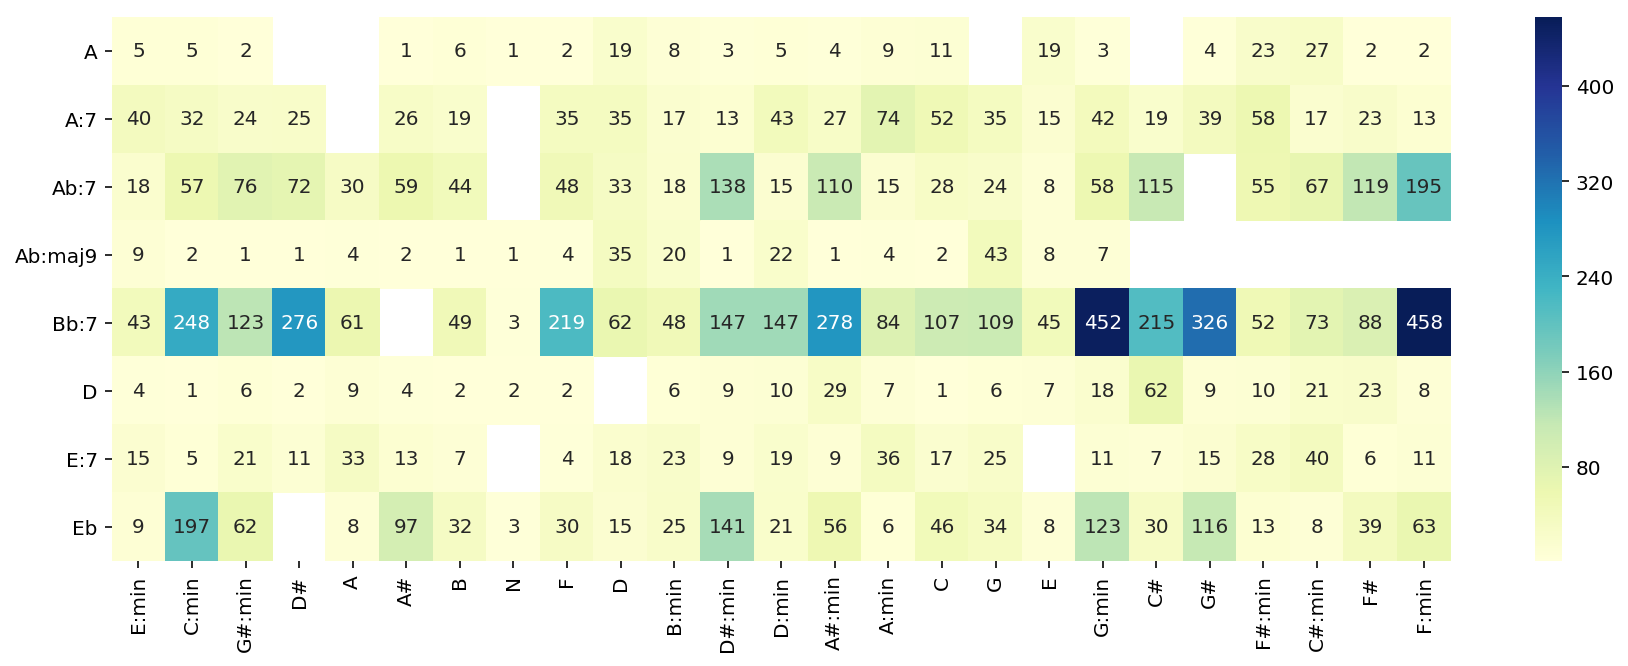

by frame chord mistake heatmap on blues:


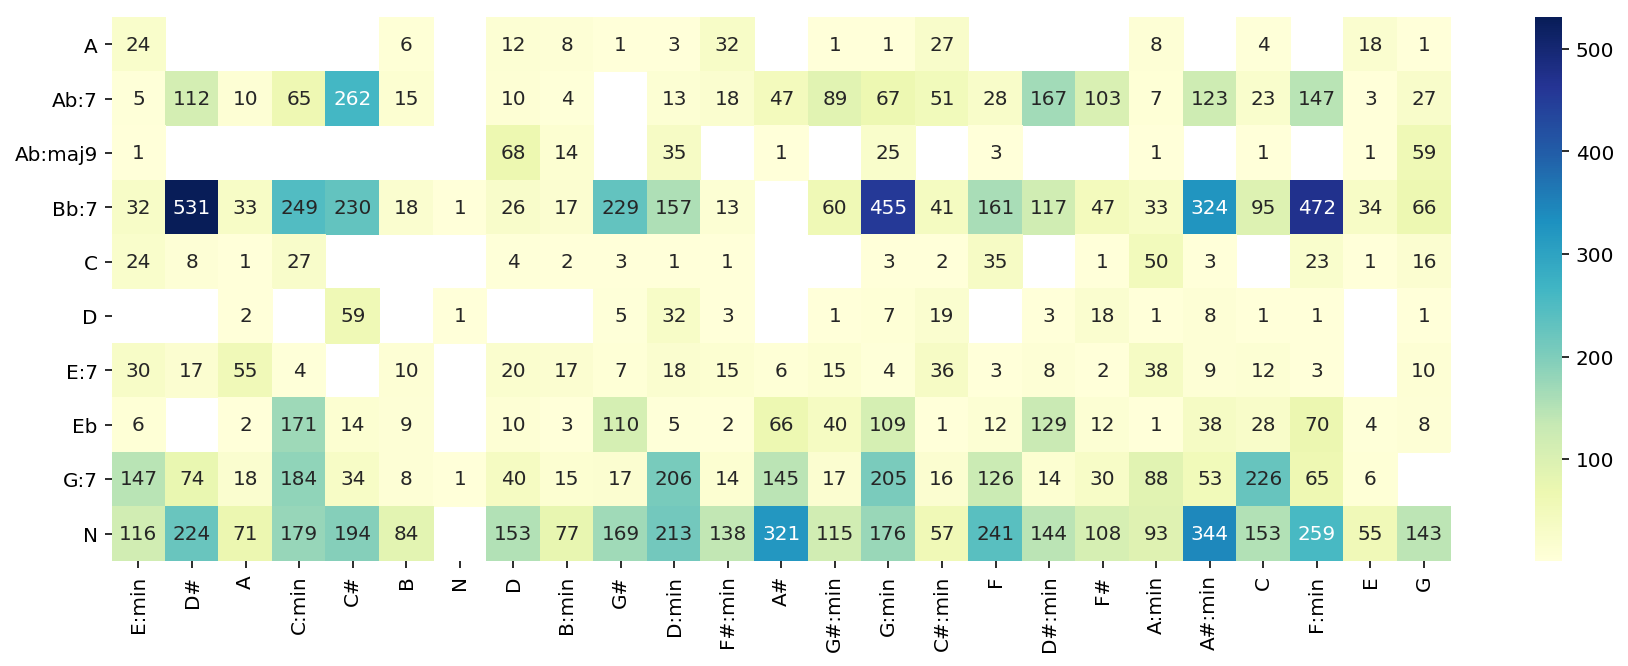

In [73]:
top_mistakes = create_top_mistakes_dictionary(blues_top_20_beat_mistakes, dict_foreachchord_beat_all)
output_filename = './results/blues_top_mistakes_beat_heatmap'

print("by beat chord mistake heatmap on blues:")
fig = make_heatmap(top_mistakes, output_filename, big=False)


print("by frame chord mistake heatmap on blues:")
top_mistakes = create_top_mistakes_dictionary(blues_top_20_frame_mistakes, dict_foreachchord_frame_all)
output_filename = './results/blues_top_mistakes_frame_heatmap'
fig = make_heatmap(top_mistakes, output_filename, big=False)


## old jazz

In [74]:
audios_path = './audios/'

output_persist_path_oldjazz = './results/estimation_jsons_old_jazz_subset/'

old_jazz_tracks = createTrackList(old_jazz_subset)

create_new_dicionaries(old_jazz_tracks, output_persist_path_oldjazz)

All tracks have been processed, they were stored in .json files in ./results/estimation_jsons_old_jazz_subset/


In [93]:
#compute score mean for Old jazz
subset_tracks = old_jazz_tracks.copy() 

#load and create aggregation for mistakes count dictionary:
oldjazz_beats_mistakes_count = load_json_as_dict(output_persist_path_oldjazz+"global_beats_mistakes_count")
oldjazz_frames_mistakes_count = load_json_as_dict(output_persist_path_oldjazz+"global_frames_mistakes_count")
oldjazz_dict_comparelabels_beat = create_aggregated_dict(subset_tracks, oldjazz_beats_mistakes_count)
oldjazz_dict_comparelabels_frame = create_aggregated_dict(subset_tracks, oldjazz_frames_mistakes_count)

#load and create aggregation for mistakes by chord  dictionary:
oldjazz_beats_mistakes_by_chord = load_json_as_dict(output_persist_path_oldjazz+"global_beats_mistakes_by_chord")
oldjazz_frames_mistakes_by_chord = load_json_as_dict(output_persist_path_oldjazz+"global_frames_mistakes_by_chord")
oldjazz_foreachchord_beat_all = create_aggregated_by_chord_dict(subset_tracks,global_beats_mistakes_by_chord)
oldjazz_foreachchord_frame_all = create_aggregated_by_chord_dict(subset_tracks, global_frames_mistakes_by_chord)



#print MEAN
beats_scores = load_json_as_dict(output_persist_path_oldjazz+"global_beats_scores")
frames_scores = load_json_as_dict(output_persist_path_oldjazz+"global_frames_scores")

print("Old Jazz accuracy of chord detection by beat: ", compute_score_mean(beats_scores), output_persist_path_oldjazz)
print("Old jazz accuracy of chord detection by frame: ", compute_score_mean(frames_scores), output_persist_path_oldjazz)


Old Jazz accuracy of chord detection by beat:  0.2707854737395302 ./results/estimation_jsons_old_jazz_subset/
Old jazz accuracy of chord detection by frame:  0.3564996347671489 ./results/estimation_jsons_old_jazz_subset/


In [79]:
oldjazz_top_20_beat_mistakes = get_top_20_mistakes_and_save_csv(oldjazz_dict_comparelabels_beat, './results/oldjazz_top_20_mistakes_beat')

#we display the top 5 below:
oldjazz_top_20_beat_mistakes.head(5)


,chord pairs,count
0,"['Bb:7', 'F:min']",218
1,"['Ab', 'F:min']",160
2,"['Eb:7', 'G#']",158
3,"['Eb:7', 'A#:min']",156
4,"['Eb:7', 'C:min']",147


In [81]:
oldjazz_top_20_frame_mistakes = get_top_20_mistakes_and_save_csv(oldjazz_dict_comparelabels_frame, './results/oldjazz_20_mistakes_frame')

#we display the top 5 below:
oldjazz_top_20_frame_mistakes.head(5)


,chord pairs,count
0,"['F:7', 'A#']",227
1,"['Eb:7', 'G#']",219
2,"['Bb:7', 'F:min']",213
3,"['Bb:7', 'D#']",192
4,"['C:7', 'F']",185


by beat chord mistake heatmap on oldjazz:


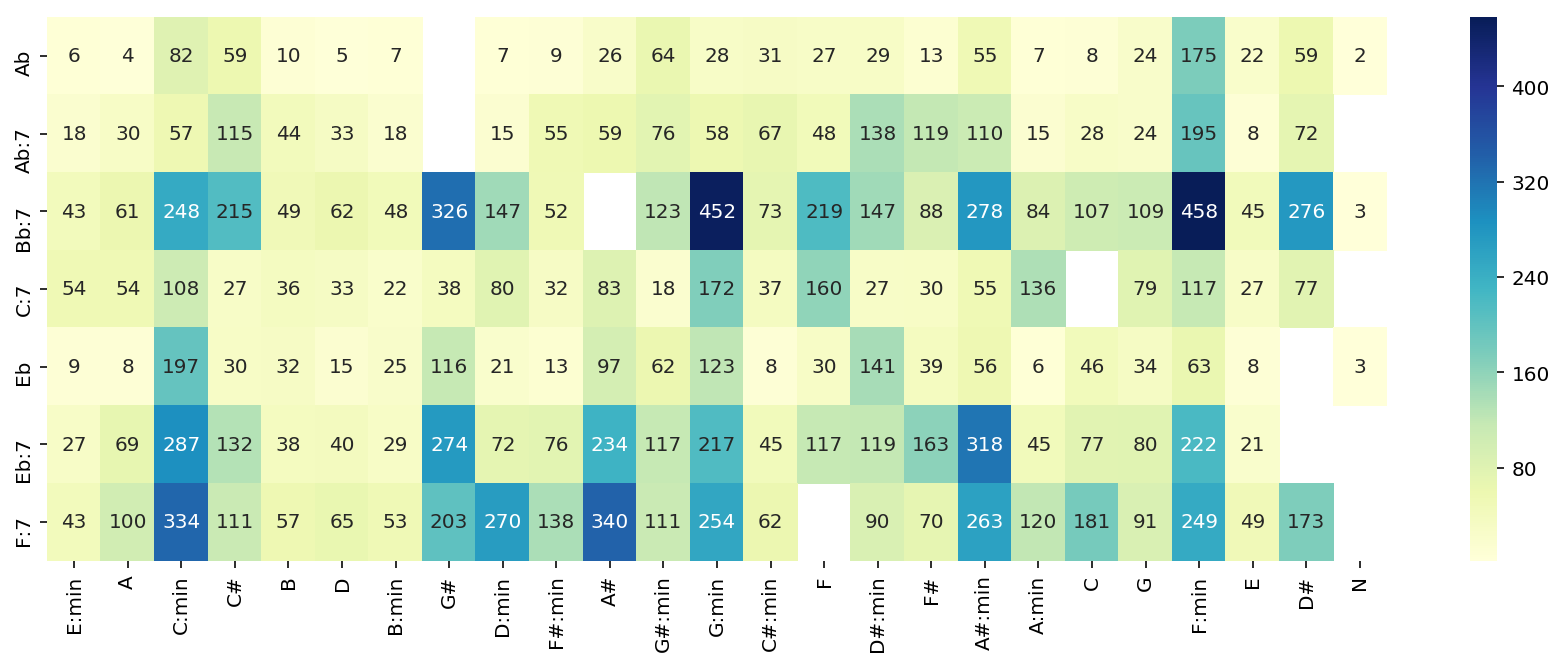

by frame chord mistake heatmap on oldjazz:


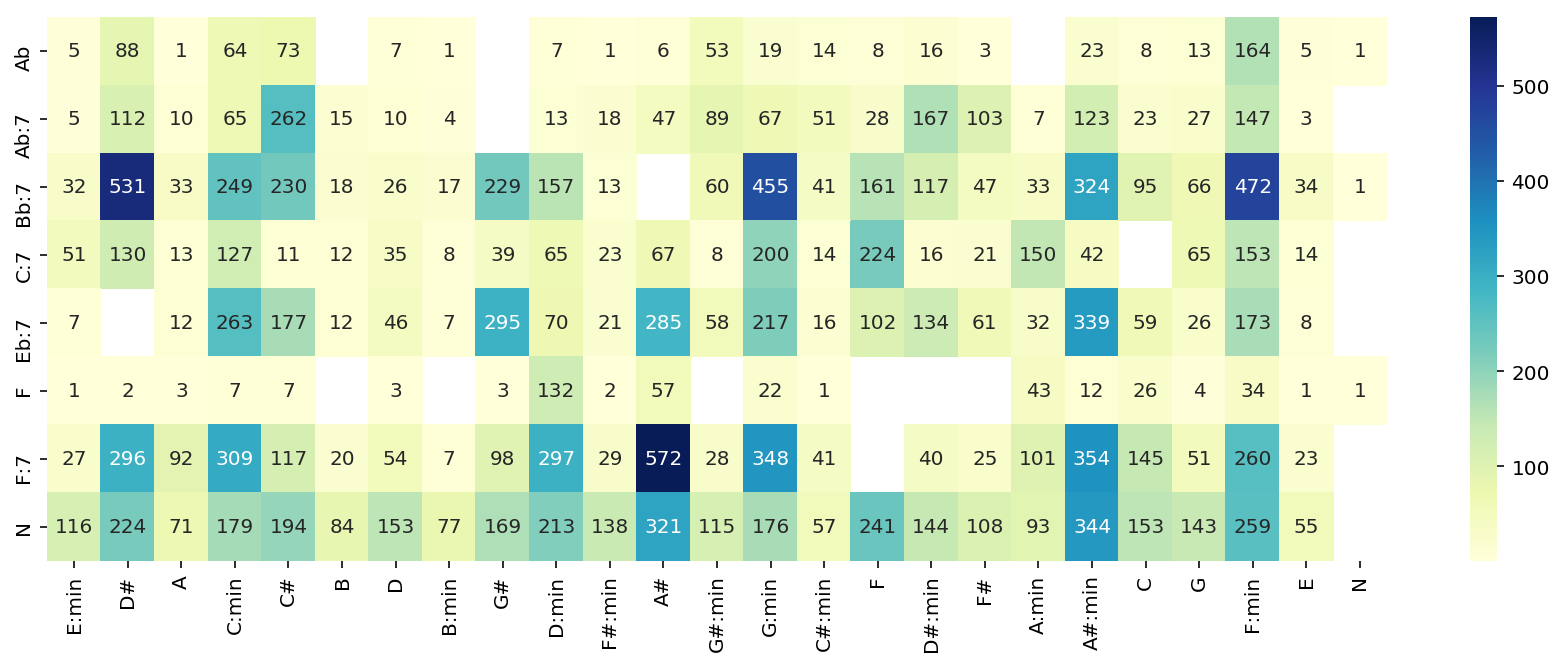

In [82]:
top_mistakes = create_top_mistakes_dictionary(oldjazz_top_20_beat_mistakes, dict_foreachchord_beat_all)
output_filename = './results/oldjazz_top_mistakes_beat_heatmap'

print("by beat chord mistake heatmap on oldjazz:")
fig = make_heatmap(top_mistakes, output_filename, big=False)


print("by frame chord mistake heatmap on oldjazz:")
top_mistakes = create_top_mistakes_dictionary(oldjazz_top_20_frame_mistakes, dict_foreachchord_frame_all)
output_filename = './results/oldjazz_top_mistakes_frame_heatmap'
fig = make_heatmap(top_mistakes, output_filename, big=False)


## new_jazz_no_bop standards

In [85]:
audios_path = './audios/'

output_persist_path_new_jazz_no_bop = './results/estimation_jsons_new_jazz_no_bop_subset/'

new_jazz_no_bop_tracks = createTrackList(new_jazz_no_bop_standards)

create_subset_dictionaries(new_jazz_no_bop_tracks, output_json_path)

All tracks have been processed, they were stored in .json files in ./results/estimation_jsons_new_jazz_no_bop_subset/


In [94]:
#compute score mean for New Jazz No Bop
subset_tracks = new_jazz_no_bop_tracks.copy()  

#load and create aggregation for mistakes count dictionary:
new_jazz_no_bop_beats_mistakes_count = load_json_as_dict(output_persist_path_new_jazz_no_bop+"global_beats_mistakes_count")
new_jazz_no_bop_frames_mistakes_count = load_json_as_dict(output_persist_path_new_jazz_no_bop+"global_frames_mistakes_count")
new_jazz_no_bop_dict_comparelabels_beat = create_aggregated_dict(subset_tracks, new_jazz_no_bop_beats_mistakes_count)
new_jazz_no_bop_dict_comparelabels_frame = create_aggregated_dict(subset_tracks, new_jazz_no_bop_frames_mistakes_count)

#load and create aggregation for mistakes by chord  dictionary:
new_jazz_no_bop_beats_mistakes_by_chord = load_json_as_dict(output_persist_path_new_jazz_no_bop+"global_beats_mistakes_by_chord")
new_jazz_no_bop_frames_mistakes_by_chord = load_json_as_dict(output_persist_path_new_jazz_no_bop+"global_frames_mistakes_by_chord")
new_jazz_no_bop_foreachchord_beat_all = create_aggregated_by_chord_dict(subset_tracks,global_beats_mistakes_by_chord)
new_jazz_no_bop_foreachchord_frame_all = create_aggregated_by_chord_dict(subset_tracks, global_frames_mistakes_by_chord)



#print MEAN
beats_scores = load_json_as_dict(output_persist_path_new_jazz_no_bop+"global_beats_scores")
frames_scores = load_json_as_dict(output_persist_path_new_jazz_no_bop+"global_frames_scores")

print("New Jazz(no bop) accuracy of chord detection by beat: ", compute_score_mean(beats_scores), output_persist_path_new_jazz_no_bop)
print("New Jazz (no bop) of chord detection by frame: ", compute_score_mean(frames_scores), output_persist_path_new_jazz_no_bop)


New Jazz (no bop) accuracy of chord detection by beat:  0.16639215069438243 ./results/estimation_jsons_new_jazz_no_bop_subset/
New Jazz (no bop) of chord detection by frame:  0.2641469586484793 ./results/estimation_jsons_new_jazz_no_bop_subset/


In [87]:
new_jazz_no_bop_top_20_beat_mistakes = get_top_20_mistakes_and_save_csv(new_jazz_no_bop_dict_comparelabels_beat, './results/new_jazz_no_bop_top_20_mistakes_beat')

#we display the top 5 below:
new_jazz_no_bop_top_20_beat_mistakes.head(5)


,chord pairs,count
0,"['Bb:7', 'G:min']",169
1,"['F:7', 'C:min']",160
2,"['F:7', 'A#']",146
3,"['F:7', 'A#:min']",136
4,"['F:7', 'G:min']",131


In [88]:
new_jazz_no_bop_top_20_frame_mistakes = get_top_20_mistakes_and_save_csv(new_jazz_no_bop_dict_comparelabels_frame, './results/new_jazz_no_bop_20_mistakes_frame')

#we display the top 5 below:
new_jazz_no_bop_top_20_frame_mistakes.head(5)


,chord pairs,count
0,"['F:7', 'A#']",262
1,"['Bb:7', 'D#']",218
2,"['Bb:7', 'G:min']",214
3,"['F:7', 'G:min']",193
4,"['F:7', 'C:min']",177


by beat chord mistake heatmap on new_jazz_no_bop:


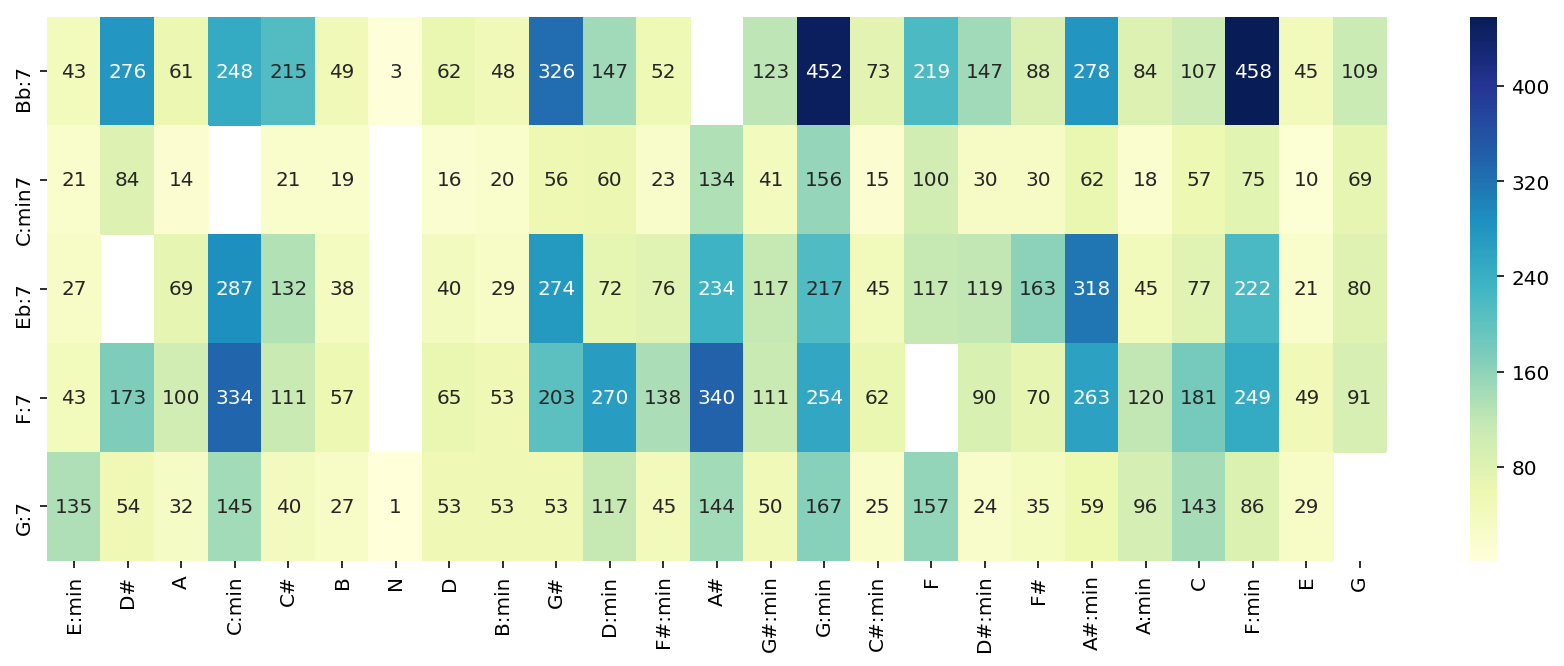

by frame chord mistake heatmap on new_jazz_no_bop:


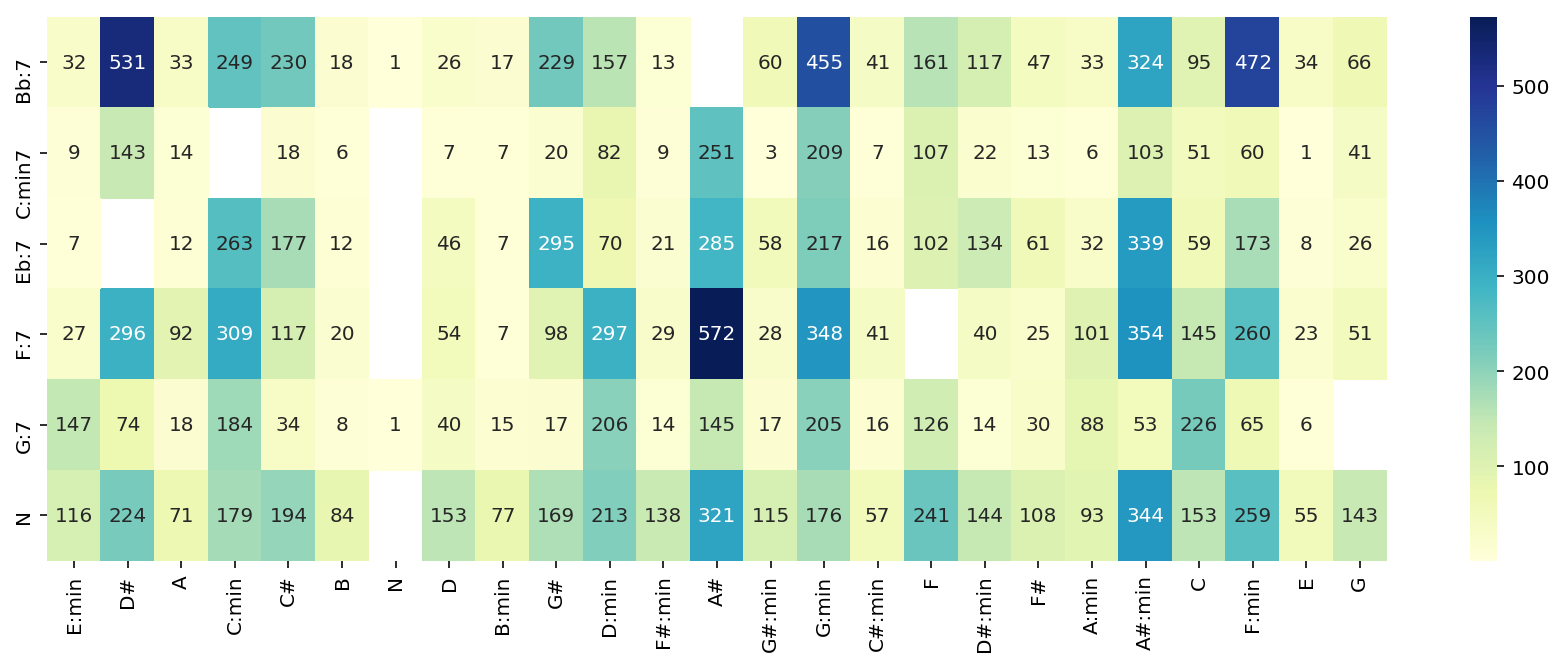

In [89]:
top_mistakes = create_top_mistakes_dictionary(new_jazz_no_bop_top_20_beat_mistakes, dict_foreachchord_beat_all)
output_filename = './results/new_jazz_no_bop_top_mistakes_beat_heatmap'

print("by beat chord mistake heatmap on new_jazz_no_bop:")
fig = make_heatmap(top_mistakes, output_filename, big=False)


print("by frame chord mistake heatmap on new_jazz_no_bop:")
top_mistakes = create_top_mistakes_dictionary(new_jazz_no_bop_top_20_frame_mistakes, dict_foreachchord_frame_all)
output_filename = './results/new_jazz_no_bop_top_mistakes_frame_heatmap'
fig = make_heatmap(top_mistakes, output_filename, big=False)


# bop subset

In [40]:
audios_path = './audios/'
output_json_path = './results/estimation_jsons_bop_subset/'

bop_tracks = createTrackList(bop_subset)

create_subset_dictionaries(bop_tracks, output_json_path)

All tracks have been processed, they were stored in .json files in ./results/estimation_jsons_bop_subset/


In [96]:
#compute score mean for BOP
subset_dict_path = './results/estimation_jsons_bop_subset/'
subset_tracks = bop_tracks.copy()

#load and create aggregation for mistakes count dictionary:
bop_beats_mistakes_count = load_json_as_dict(subset_dict_path+"global_beats_mistakes_count")
bop_frames_mistakes_count = load_json_as_dict(subset_dict_path+"global_frames_mistakes_count")
bop_dict_comparelabels_beat = create_aggregated_dict(subset_tracks, global_beats_mistakes_count)
bop_dict_comparelabels_frame = create_aggregated_dict(subset_tracks, global_frames_mistakes_count)

#load and create aggregation for mistakes by chord  dictionary:
bop_beats_mistakes_by_chord = load_json_as_dict(subset_dict_path+"global_beats_mistakes_by_chord")
bop_frames_mistakes_by_chord = load_json_as_dict(subset_dict_path+"global_frames_mistakes_by_chord")
bop_foreachchord_beat_all = create_aggregated_by_chord_dict(subset_tracks,global_beats_mistakes_by_chord)
bop_foreachchord_frame_all = create_aggregated_by_chord_dict(subset_tracks, global_frames_mistakes_by_chord)



#print MEAN
beats_scores = load_json_as_dict(subset_dict_path+"global_beats_scores")
frames_scores = load_json_as_dict(subset_dict_path+"global_frames_scores")

print("Bop accuracy of chord detection by beat: ", compute_score_mean(beats_scores), subset_dict_path)
print("Bop accuracy of chord detection by frame: ", compute_score_mean(frames_scores), subset_dict_path)


Bop accuracy of chord detection by beat:  0.15505507244173625 ./results/estimation_jsons_bop_subset/
Bop accuracy of chord detection by frame:  0.23769120337658042 ./results/estimation_jsons_bop_subset/


In [43]:
bop_top_20_beat_mistakes = get_top_20_mistakes_and_save_csv(bop_dict_comparelabels_beat, './results/bop_top_20_mistakes_beat')

#we display the top 5 below:
bop_top_20_beat_mistakes.head(5)

,chord pairs,count
0,"['Bb:7', 'F:min']",142
1,"['Bb:7', 'G:min']",113
2,"['N', 'A#:min']",101
3,"['Bb:7', 'G#']",98
4,"['N', 'G#']",96


In [58]:
bop_top_20_frame_mistakes = get_top_20_mistakes_and_save_csv(bop_dict_comparelabels_frame, './results/bop_20_mistakes_frame')

#we display the top 5 below:
bop_top_20_frame_mistakes.head(5)


,chord pairs,count
0,"['N', 'A#:min']",129
1,"['Bb:7', 'F:min']",126
2,"['N', 'A#']",116
3,"['Bb:7', 'G:min']",114
4,"['N', 'F:min']",109


by beat chord mistake heatmap....


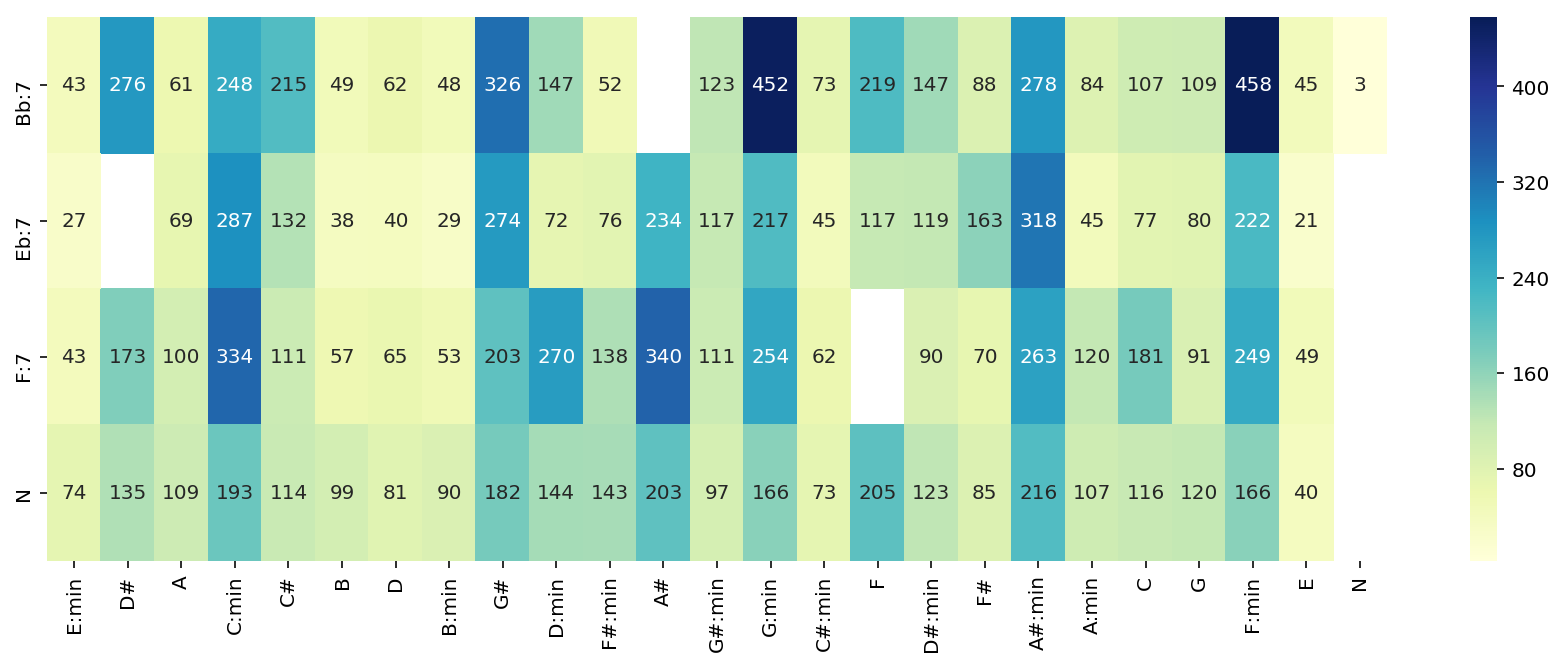

by frame chord mistake heatmap....


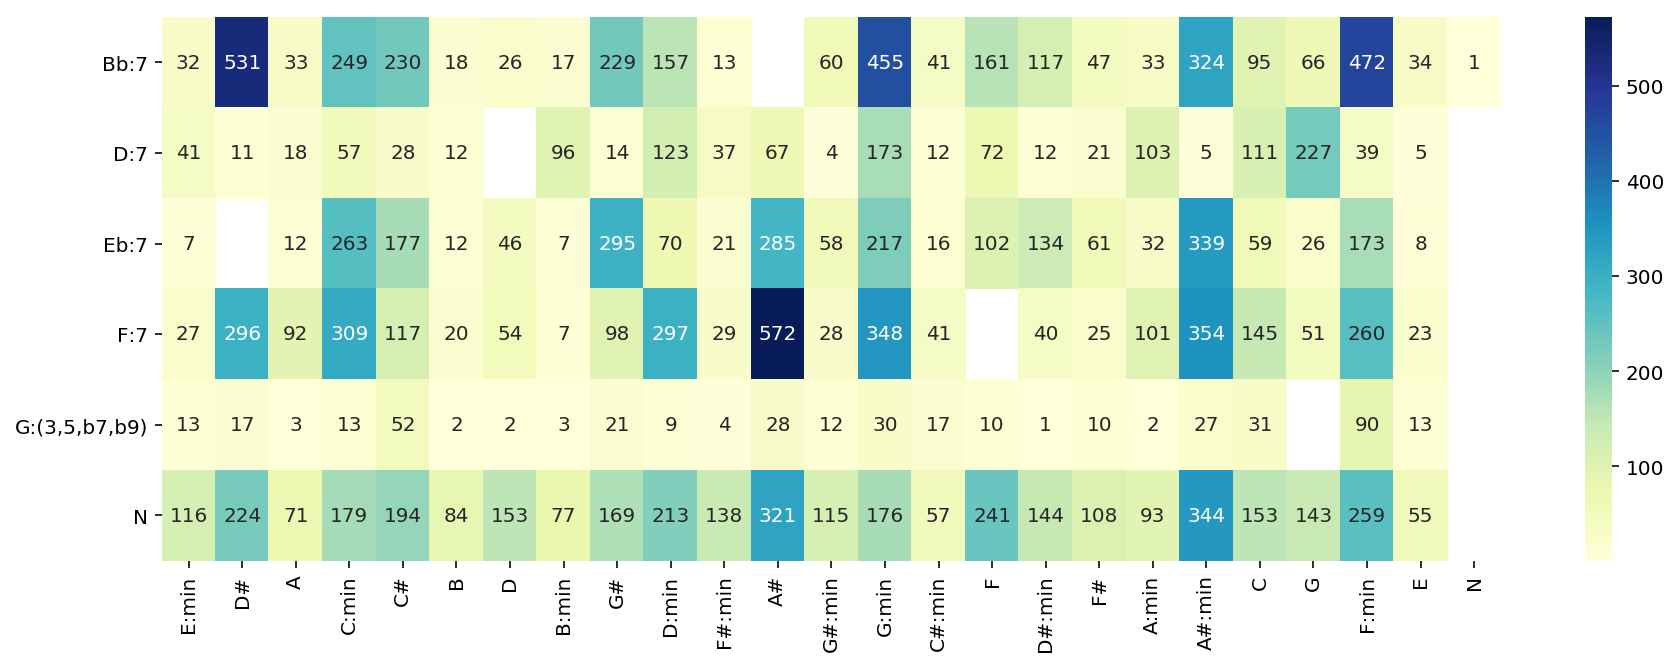

In [61]:
top_mistakes = create_top_mistakes_dictionary(bop_top_20_beat_mistakes, dict_foreachchord_beat_all)
output_filename = './results/bop_top_mistakes_beat_heatmap'

print("by beat chord mistake heatmap:")
fig = make_heatmap(top_mistakes, output_filename, big=False)


print("by frame chord mistake heatmap:")
top_mistakes = create_top_mistakes_dictionary(bop_top_20_frame_mistakes, dict_foreachchord_frame_all)
output_filename = './results/bop_top_mistakes_frame_heatmap'
fig = make_heatmap(top_mistakes, output_filename, big=False)


# all_new_jazz subset

In [101]:
audios_path = './audios/'

output_persist_path_all_new_jazz = './results/estimation_jsons_all_new_jazz/'

all_new_jazz_tracks = createTrackList(all_new_jazz)

create_subset_dictionaries(all_new_jazz_tracks, output_persist_path_all_new_jazz)

will create a json dictionary in:  ./results/estimation_jsons_all_new_jazz/global_beats_mistakes_count.json
will create a json dictionary in:  ./results/estimation_jsons_all_new_jazz/global_beats_mistakes_by_chord.json
will create a json dictionary in:  ./results/estimation_jsons_all_new_jazz/global_beats_scores.json
will create a json dictionary in:  ./results/estimation_jsons_all_new_jazz/global_frames_mistakes_count.json
will create a json dictionary in:  ./results/estimation_jsons_all_new_jazz/global_frames_mistakes_by_chord.json
will create a json dictionary in:  ./results/estimation_jsons_all_new_jazz/global_frames_scores.json
All tracks have been processed, they were stored in .json files in ./results/estimation_jsons_all_new_jazz/


In [102]:
#compute score mean for all_new_jazz
subset_tracks = all_new_jazz_tracks.copy() 

#load and create aggregation for mistakes count dictionary:
all_new_jazz_beats_mistakes_count = load_json_as_dict(output_persist_path_all_new_jazz+"global_beats_mistakes_count")
all_new_jazz_frames_mistakes_count = load_json_as_dict(output_persist_path_all_new_jazz+"global_frames_mistakes_count")
all_new_jazz_dict_comparelabels_beat = create_aggregated_dict(subset_tracks, all_new_jazz_beats_mistakes_count)
all_new_jazz_dict_comparelabels_frame = create_aggregated_dict(subset_tracks, all_new_jazz_frames_mistakes_count)

#load and create aggregation for mistakes by chord  dictionary:
all_new_jazz_beats_mistakes_by_chord = load_json_as_dict(output_persist_path_all_new_jazz+"global_beats_mistakes_by_chord")
all_new_jazz_frames_mistakes_by_chord = load_json_as_dict(output_persist_path_all_new_jazz+"global_frames_mistakes_by_chord")
all_new_jazz_foreachchord_beat_all = create_aggregated_by_chord_dict(subset_tracks,global_beats_mistakes_by_chord)
all_new_jazz_foreachchord_frame_all = create_aggregated_by_chord_dict(subset_tracks, global_frames_mistakes_by_chord)



#print MEAN
beats_scores = load_json_as_dict(output_persist_path_all_new_jazz+"global_beats_scores")
frames_scores = load_json_as_dict(output_persist_path_all_new_jazz+"global_frames_scores")

print("Overall accuracy of chord detection by beat: ", compute_score_mean(beats_scores), output_persist_path_all_new_jazz)
print("Overall accuracy of chord detection by frame: ", compute_score_mean(frames_scores), output_persist_path_all_new_jazz)


Overall accuracy of chord detection by beat:  0.1611015141764809 ./results/estimation_jsons_all_new_jazz/
Overall accuracy of chord detection by frame:  0.2518009395215931 ./results/estimation_jsons_all_new_jazz/


In [103]:
all_new_jazz_top_20_beat_mistakes = get_top_20_mistakes_and_save_csv(all_new_jazz_dict_comparelabels_beat, './results/all_new_jazz_top_20_mistakes_beat')

#we display the top 5 below:
all_new_jazz_top_20_beat_mistakes.head(5)


,chord pairs,count
0,"['Bb:7', 'G:min']",282
1,"['Bb:7', 'F:min']",230
2,"['F:7', 'C:min']",230
3,"['F:7', 'A#']",228
4,"['F:7', 'A#:min']",199


In [104]:
all_new_jazz_top_20_frame_mistakes = get_top_20_mistakes_and_save_csv(all_new_jazz_dict_comparelabels_frame, './results/all_new_jazz_20_mistakes_frame')

#we display the top 5 below:
all_new_jazz_top_20_frame_mistakes.head(5)


,chord pairs,count
0,"['F:7', 'A#']",367
1,"['Bb:7', 'G:min']",328
2,"['Bb:7', 'D#']",302
3,"['F:7', 'G:min']",286
4,"['F:7', 'A#:min']",252


by beat chord mistake heatmap on all_new_jazz:


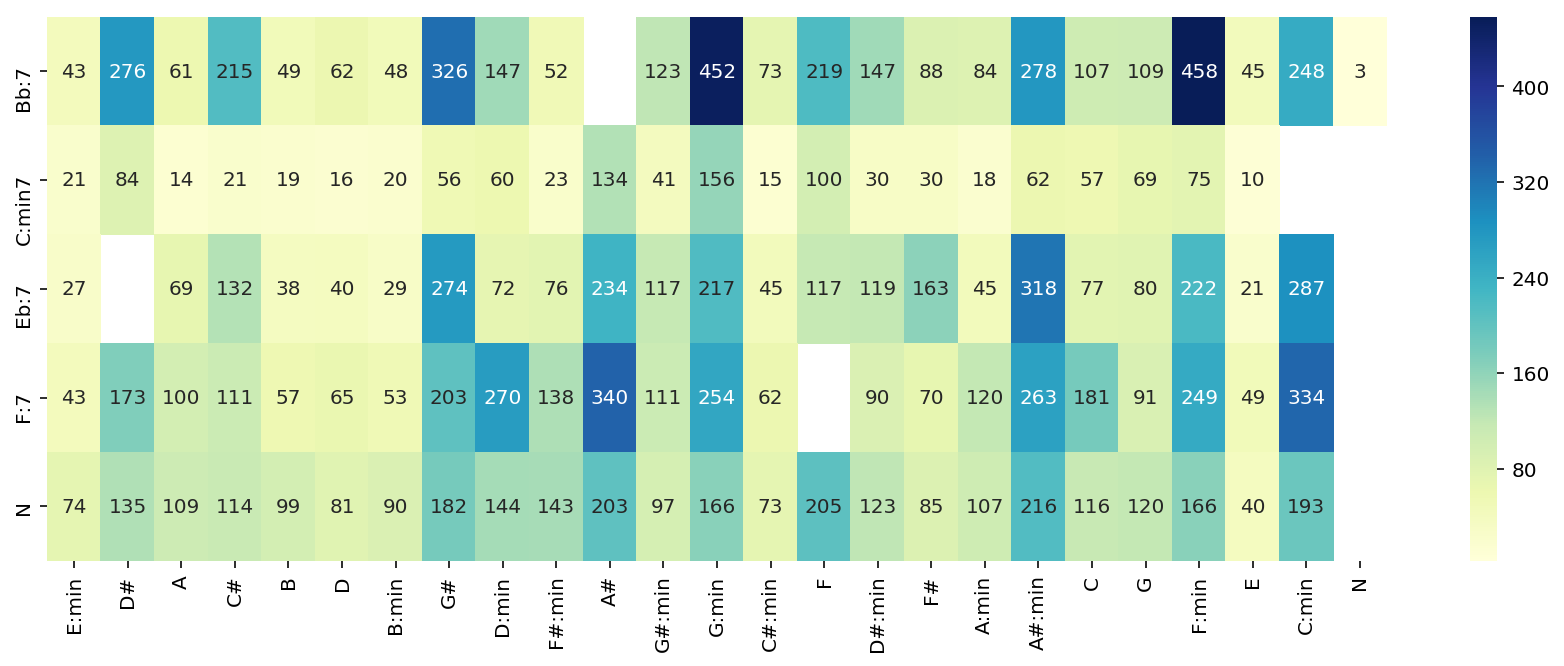

by frame chord mistake heatmap on all_new_jazz:


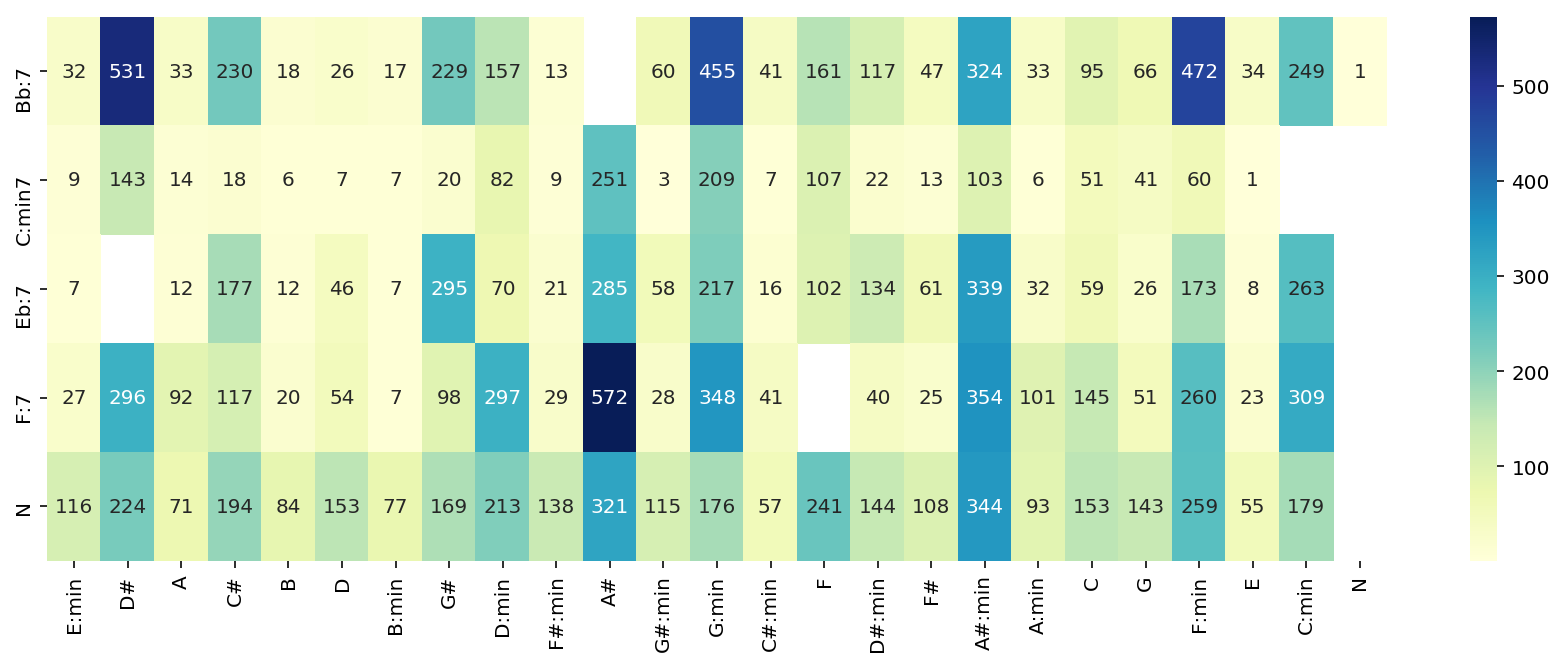

In [105]:
top_mistakes = create_top_mistakes_dictionary(all_new_jazz_top_20_beat_mistakes, dict_foreachchord_beat_all)
output_filename = './results/all_new_jazz_top_mistakes_beat_heatmap'

print("by beat chord mistake heatmap on all_new_jazz:")
fig = make_heatmap(top_mistakes, output_filename, big=False)


print("by frame chord mistake heatmap on all_new_jazz:")
top_mistakes = create_top_mistakes_dictionary(all_new_jazz_top_20_frame_mistakes, dict_foreachchord_frame_all)
output_filename = './results/all_new_jazz_top_mistakes_frame_heatmap'
fig = make_heatmap(top_mistakes, output_filename, big=False)


# Conclusion 

We conducted an experiment comparing two algorithms from Essentia, separated the JAAH dataset into distinct subsets by time periods and genres to see if ACE performs differently on them. As a result, chord detection algorithm seems to perform better on pieces that are more harmonical. 

There are few reasons that might cause such low accuracy: first of all, since chord detection algorithms in Essentia only provide identification for triads, they are destined to fail in recognizing more complex chords. Also, the two algorithms in Essentia can only identify minor and major chords, they could perform poorly when chord types such as diminished/dominant seventh/suspended/augmented/extended appear frequently in the JAAH dataset.

For the task of detecting chords in jazz music, ACE algorithm by frames performs considerably better than ACE algorithm by beats. Nevertheless, from the result we obtained from this experiment, as well as the result obtained by Vsevolod using two other state-of-the-art ACE algorithms, we can see the accuracy of chord detection algorithms are still far from human-level accuracy. In the context of harmonically complex music genres, there’s still a long way to go before any chord detection algorithm to be useful for further applications.


